# Solving Graph Coloring (Quantum Annealing)

In [2]:
import dwavebinarycsp
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import networkx as nx
import matplotlib.pyplot as plt
from dwave.cloud import Client
import neal
import time
import numpy as np
import pandas as pd

## Processing the graph 

In [3]:
def read_graph(name):
    num_vertices = 0
    num_edges = 0 
    list_edges = []
    file = open("data/" + name , "r")
    for line in file:
        tokens = line.split()
        if(tokens[0] == "c"):
            #this line is a comment
            continue
        elif(tokens[0] == "p"and tokens[1] == "edge"):
            # save number of vertices and edges
            num_vertices = tokens[2]
            num_edges = tokens[3]
        else:
            # this is a line describing an edge
            temp = (tokens[1], tokens[2])
            list_edges.append(temp)
    file.close()
    return int(num_vertices), int(num_edges), list_edges
    

In [4]:
def plotDictionary(dictionary):
    heights = []
    bars = []
    for i in dictionary:
        heights.append(int(i['num_occurrences']))
        bars.append(i['id'])
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, heights)
    plt.xticks(y_pos, bars)
    plt.ylabel('num_ocurrences')
    plt.xlabel('id')
    plt.show()

In [5]:
def plot_table(dictionary):
    return pd.DataFrame.from_dict(dictionary)

## Quantum Annealing

In [60]:
def isSampleInSamples(s, count):
    for i in range(len(count)):
        if (count[i]['energy']== s.energy):
            count[i]['num_occurrences']+= s.num_occurrences
            return True
    return False

In [7]:
def try_k_coloring(k_colors, graph_name, is_simulated = False):
    print("processing ", graph_name, "... ")
    num_vertices, num_edges, list_edges = read_graph(graph_name)
    vertices = [str(i+1) for i in range(num_vertices)]
    csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)
    one_color_configurations = set()

    def not_same_color(v1, v2):
        #constraint: not to adyacent nodes share same color
        return not (v1 and v2)

    for i in range(k_colors):
        one_color_configurations.add(tuple(1 if i == j else 0 for j in range(k_colors)))

    #constraint: just one color per vertex
    for vertex in vertices:
        variables = [vertex+"c"+str(i) for i in range(k_colors)]
        csp.add_constraint(one_color_configurations, variables)

    for edge in list_edges:
        v1, v2 = edge
        for i in range(k_colors):
            variables = [str(v1)+"c"+ str(i), str(v2)+"c" + str(i)]
            csp.add_constraint(not_same_color, variables)

    def plot_map(self):
        G = nx.Graph()
        G.add_nodes_from(vertices)
        G.add_edges_from(list_edges)
        # Translate from binary to integer color representation
        color_map = {}
        for province in vertices:
              for i in range(k_colors):
                if sample[province+"c"+str(i)]:
                    color_map[province] = i
        # Plot the sample with color-coded nodes
        node_colors = [color_map.get(node) for node in G.nodes()]
        nx.draw_circular(G, with_labels=True, node_color=node_colors, node_size=3000, cmap=plt.cm.rainbow)
        plt.show()
    
    bqm = dwavebinarycsp.stitch(csp)
    counts = []
    idSample = 0
    if not is_simulated:
        client_qpu = Client.from_config()   
        client_cpu = Client.from_config(profile='prod') 
        
        # Set up a solver using the local system’s default D-Wave Cloud Client configuration file
        # and sample 50 times
        sampler = EmbeddingComposite(DWaveSampler())         # doctest: +SKIP
        start_time = time.time()
        response = sampler.sample(bqm, num_reads=1024)         # doctest: +SKIP
        elapsed_time = time.time() - start_time
        for s in response.data():
            if not isSampleInSamples(s, counts):
                counts.append({'id': idSample,'sample':s.sample, 'num_occurrences':s.num_occurrences, 'energy':s.energy})
                idSample+=1

        # Plot the lowest-energy sample if it meets the constraints

        sample = next(response.samples())      # doctest: +SKIP
        if not csp.check(sample):              # doctest: +SKIP
            print("Failed to color map")
        else:
            plot_map(sample)
        print("execution time: ", elapsed_time)
        return counts,response
    else:
        sampler = neal.SimulatedAnnealingSampler()
        start_time = time.time()
        response = sampler.sample(bqm, num_reads=1024)
        elapsed_time = time.time() - start_time
        sample = next(response.samples())      # doctest: +SKIP

        for s in response.data():
            
            if not isSampleInSamples(s, counts):
                counts.append({'id': idSample,'sample':s.sample, 'num_occurrences':s.num_occurrences, 'energy':s.energy})
                idSample+=1
                
        if not csp.check(sample):              # doctest: +SKIP
            print("Failed to color map")
        else:
            plot_map(sample)
        print("execution time: ", elapsed_time)
        return counts, response

# Test 1

## Quantum Computer Results

processing  graph1.txt ... 


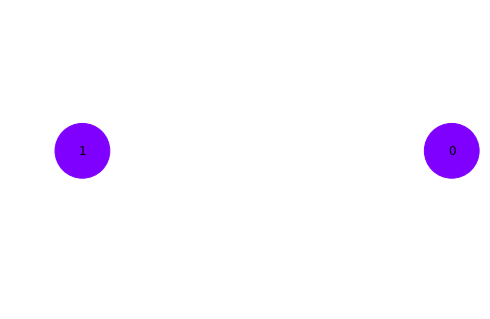

execution time:  2.8488409519195557


In [155]:
answer = try_k_coloring(1, "graph1.txt")

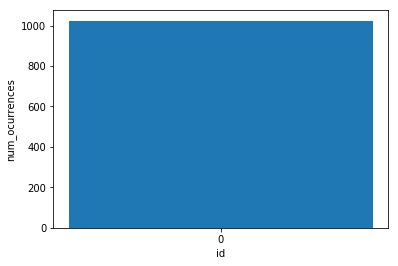

In [156]:
plotDictionary(answer)

In [40]:
answer[1]

SampleSet(rec.array([([1, 1], -2., 1024, 0.)],
          dtype=[('sample', 'i1', (2,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), ['1c0', '2c0'], {'timing': {'qpu_sampling_time': 167895, 'qpu_anneal_time_per_sample': 20, 'qpu_readout_time_per_sample': 123, 'qpu_access_time': 175422, 'qpu_access_overhead_time': 1293, 'qpu_programming_time': 7527, 'qpu_delay_time_per_sample': 21, 'total_post_processing_time': 967, 'post_processing_overhead_time': 967, 'total_real_time': 175422, 'run_time_chip': 167895, 'anneal_time_per_run': 20, 'readout_time_per_run': 123}}, 'BINARY')

## Simulator Results

processing  graph1.txt ... 


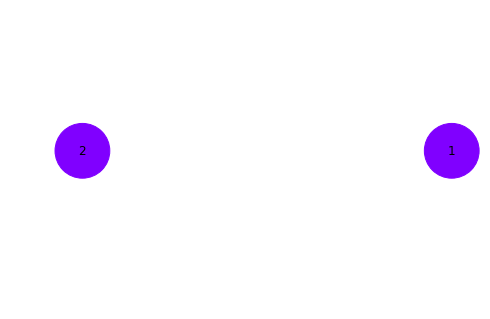

execution time:  0.035592079162597656


In [11]:
answer2 = try_k_coloring(1, "graph1.txt", True)

In [12]:
answer2[0]

[{'id': 0,
  'sample': {'1c0': 1, '2c0': 1},
  'num_occurrences': 1024,
  'energy': -2.0}]

# Test 2

## 1-color test (simulator)

In [165]:
answer2 = try_k_coloring(1, "graph2.txt", True)

processing  graph2.txt ... 
Failed to color map
execution time:  0.023420095443725586


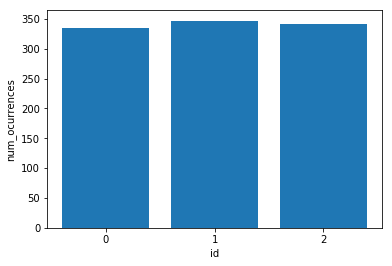

In [160]:
plotDictionary(answer2)

In [162]:
plot_table(answer2)

,energy,id,num_occurrences,sample
0,0.0,0,335,"{'1c0': 0, '2c0': 1}"
1,0.0,1,347,"{'1c0': 1, '2c0': 0}"
2,0.0,2,342,"{'1c0': 1, '2c0': 1}"


## 2-color

## Quantum Computer Results

processing  graph2.txt ... 


/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


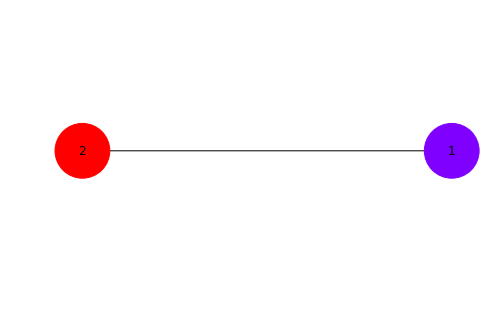

execution time:  2.126063823699951


In [166]:
answer2 = try_k_coloring(2, "graph2.txt")

In [45]:
answer2[1]

SampleSet(rec.array([([0, 1, 1, 0], -2., 508, 0.), ([1, 0, 0, 1], -2., 516, 0.)],
          dtype=[('sample', 'i1', (4,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), ['1c0', '1c1', '2c0', '2c1'], {'timing': {'qpu_sampling_time': 167895, 'qpu_anneal_time_per_sample': 20, 'qpu_readout_time_per_sample': 123, 'qpu_access_time': 175433, 'qpu_access_overhead_time': 2304, 'qpu_programming_time': 7538, 'qpu_delay_time_per_sample': 21, 'total_post_processing_time': 330, 'post_processing_overhead_time': 330, 'total_real_time': 175433, 'run_time_chip': 167895, 'anneal_time_per_run': 20, 'readout_time_per_run': 123}}, 'BINARY')

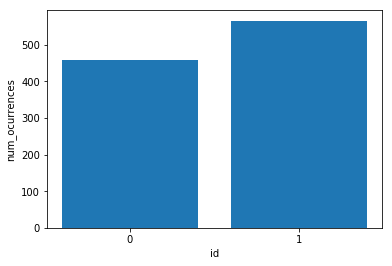

In [167]:
plotDictionary(answer2)

In [168]:
plot_table(answer2)

,energy,id,num_occurrences,sample
0,-2.0,0,458,"{'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1}"
1,-2.0,1,566,"{'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0}"


## Simulator Results

processing  graph2.txt ... 


/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


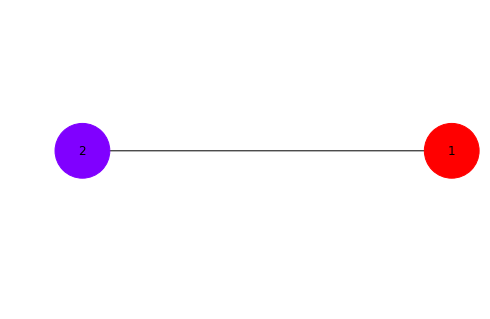

execution time:  0.10178613662719727


[{'id': 0,
  'sample': {'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0},
  'num_occurrences': 532,
  'energy': -2.0},
 {'id': 1,
  'sample': {'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1},
  'num_occurrences': 492,
  'energy': -2.0}]

In [13]:
answer2 = try_k_coloring(2, "graph2.txt", True)
answer2[0]

# Test 3

## Quantum Computer Results

processing  graph3.txt ... 


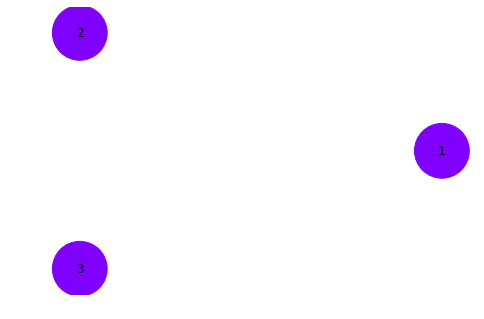

execution time:  2.622627019882202


In [169]:
answer2 = try_k_coloring(1, "graph3.txt")

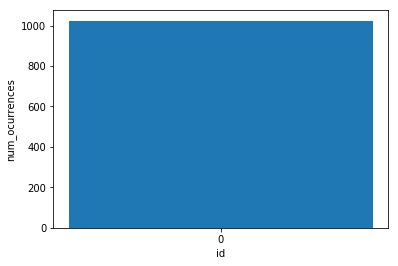

In [170]:
plotDictionary(answer2)

In [171]:
plot_table(answer2)

,energy,id,num_occurrences,sample
0,-3.0,0,1024,"{'1c0': 1, '2c0': 1, '3c0': 1}"


In [47]:
answer2[1]

SampleSet(rec.array([([1, 1, 1], -3., 1024, 0.)],
          dtype=[('sample', 'i1', (3,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), ['1c0', '2c0', '3c0'], {'timing': {'qpu_sampling_time': 167895, 'qpu_anneal_time_per_sample': 20, 'qpu_readout_time_per_sample': 123, 'qpu_access_time': 175430, 'qpu_access_overhead_time': 1707, 'qpu_programming_time': 7535, 'qpu_delay_time_per_sample': 21, 'total_post_processing_time': 3784, 'post_processing_overhead_time': 3784, 'total_real_time': 175430, 'run_time_chip': 167895, 'anneal_time_per_run': 20, 'readout_time_per_run': 123}}, 'BINARY')

## Simulator Results

processing  graph3.txt ... 


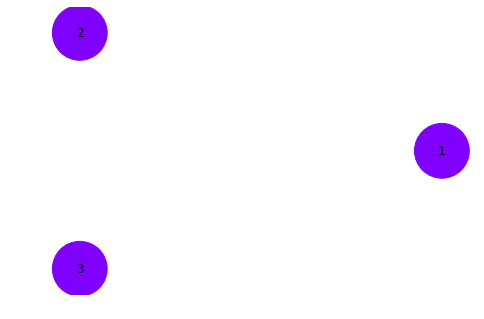

execution time:  0.042475223541259766


[{'id': 0,
  'sample': {'1c0': 1, '2c0': 1, '3c0': 1},
  'num_occurrences': 1024,
  'energy': -3.0}]

In [14]:
answer2 = try_k_coloring(1, "graph3.txt", True)
answer2[0]

# Test 4

## Quantum Computer Results

processing  graph4.txt ... 


/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


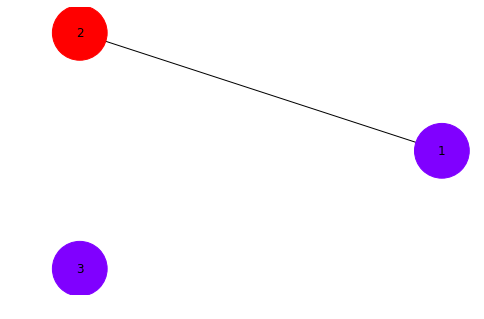

execution time:  2.183976888656616


In [172]:
answer2 = try_k_coloring(2, "graph4.txt")

In [49]:
answer2[1]

SampleSet(rec.array([([0, 1, 1, 0, 1, 0], -3., 242, 0.),
           ([0, 1, 1, 0, 0, 1], -3., 228, 0.),
           ([1, 0, 0, 1, 1, 0], -3., 289, 0.),
           ([1, 0, 0, 1, 0, 1], -3., 262, 0.),
           ([0, 0, 0, 1, 0, 1], -1.,   1, 0.),
           ([1, 0, 0, 0, 0, 1], -1.,   1, 0.),
           ([1, 0, 0, 1, 0, 0], -1.,   1, 0.)],
          dtype=[('sample', 'i1', (6,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), ['1c0', '1c1', '2c0', '2c1', '3c0', '3c1'], {'timing': {'qpu_sampling_time': 167895, 'qpu_anneal_time_per_sample': 20, 'qpu_readout_time_per_sample': 123, 'qpu_access_time': 175436, 'qpu_access_overhead_time': 1203, 'qpu_programming_time': 7541, 'qpu_delay_time_per_sample': 21, 'total_post_processing_time': 362, 'post_processing_overhead_time': 362, 'total_real_time': 175436, 'run_time_chip': 167895, 'anneal_time_per_run': 20, 'readout_time_per_run': 123}}, 'BINARY')

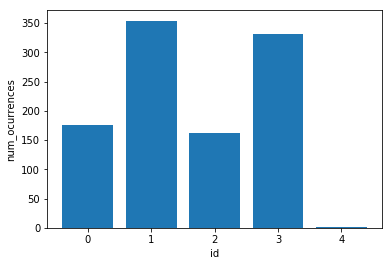

In [173]:
plotDictionary(answer2)

In [175]:
t = plot_table(answer2)
t

,energy,id,num_occurrences,sample
0,-3.0,0,175,"{'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0'..."
1,-3.0,1,354,"{'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0'..."
2,-3.0,2,162,"{'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0'..."
3,-3.0,3,332,"{'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0'..."
4,-1.0,4,1,"{'1c0': 0, '1c1': 0, '2c0': 0, '2c1': 1, '3c0'..."


In [177]:
answer2

[{'id': 0,
  'sample': {'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0': 1, '3c1': 0},
  'num_occurrences': 175,
  'energy': -3.0},
 {'id': 1,
  'sample': {'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0': 0, '3c1': 1},
  'num_occurrences': 354,
  'energy': -3.0},
 {'id': 2,
  'sample': {'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0': 1, '3c1': 0},
  'num_occurrences': 162,
  'energy': -3.0},
 {'id': 3,
  'sample': {'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0': 0, '3c1': 1},
  'num_occurrences': 332,
  'energy': -3.0},
 {'id': 4,
  'sample': {'1c0': 0, '1c1': 0, '2c0': 0, '2c1': 1, '3c0': 0, '3c1': 1},
  'num_occurrences': 1,
  'energy': -1.0}]

## Simulator Results

processing  graph4.txt ... 


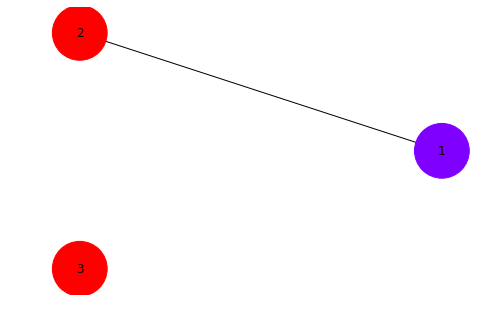

execution time:  0.08333897590637207


[{'id': 0,
  'sample': {'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0': 0, '3c1': 1},
  'num_occurrences': 276,
  'energy': -3.0},
 {'id': 1,
  'sample': {'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0': 1, '3c1': 0},
  'num_occurrences': 252,
  'energy': -3.0},
 {'id': 2,
  'sample': {'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0': 0, '3c1': 1},
  'num_occurrences': 248,
  'energy': -3.0},
 {'id': 3,
  'sample': {'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0': 1, '3c1': 0},
  'num_occurrences': 248,
  'energy': -3.0}]

In [15]:
answer2 = try_k_coloring(2, "graph4.txt", True)
answer2[0]

# Test 5

## Quantum Computer Results

processing  graph5.txt ... 


/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


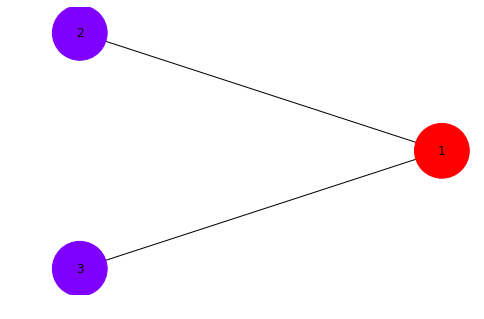

execution time:  2.1911280155181885


In [178]:
answer2 = try_k_coloring(2, "graph5.txt")

In [52]:
answer2[1]

SampleSet(rec.array([([1, 0, 0, 1, 0, 1], -3., 508, 0.),
           ([0, 1, 1, 0, 1, 0], -3., 515, 0.),
           ([0, 1, 1, 0, 0, 0], -1.,   1, 0.)],
          dtype=[('sample', 'i1', (6,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), ['1c0', '1c1', '2c0', '2c1', '3c0', '3c1'], {'timing': {'qpu_sampling_time': 167895, 'qpu_anneal_time_per_sample': 20, 'qpu_readout_time_per_sample': 123, 'qpu_access_time': 175432, 'qpu_access_overhead_time': 1993, 'qpu_programming_time': 7537, 'qpu_delay_time_per_sample': 21, 'total_post_processing_time': 2011, 'post_processing_overhead_time': 2011, 'total_real_time': 175432, 'run_time_chip': 167895, 'anneal_time_per_run': 20, 'readout_time_per_run': 123}}, 'BINARY')

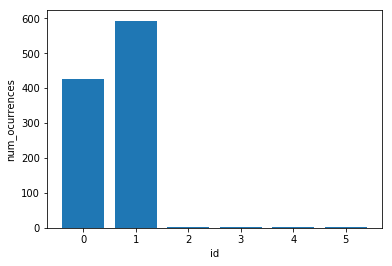

In [179]:
plotDictionary(answer2)

In [180]:
t = plot_table(answer2)
t

,energy,id,num_occurrences,sample
0,-3.0,0,426,"{'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0'..."
1,-3.0,1,593,"{'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0'..."
2,-1.0,2,2,"{'1c0': 0, '1c1': 0, '2c0': 0, '2c1': 1, '3c0'..."
3,-1.0,3,1,"{'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 0, '3c0'..."
4,-1.0,4,1,"{'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0'..."
5,-1.0,5,1,"{'1c0': 0, '1c1': 0, '2c0': 1, '2c1': 0, '3c0'..."


## Simulator Results

processing  graph5.txt ... 


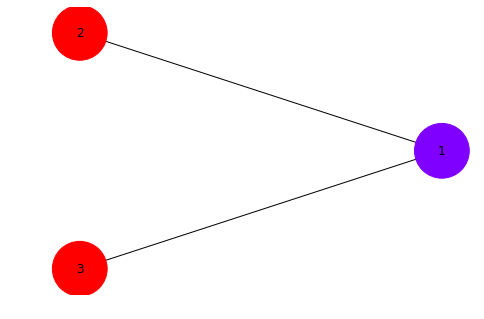

execution time:  0.08876180648803711


[{'id': 0,
  'sample': {'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0': 0, '3c1': 1},
  'num_occurrences': 524,
  'energy': -3.0},
 {'id': 1,
  'sample': {'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0': 1, '3c1': 0},
  'num_occurrences': 500,
  'energy': -3.0}]

In [21]:
answer2 = try_k_coloring(2, "graph5.txt", True)
answer2[0]

# Test 6

## Quantum Computer Results

processing  graph6.txt ... 


/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


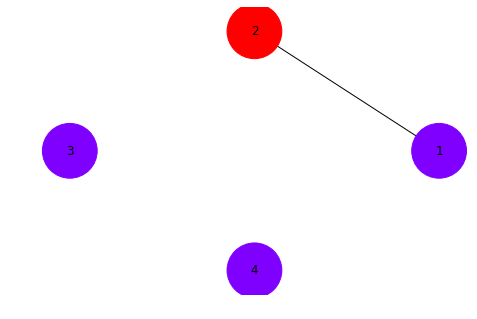

execution time:  2.4530370235443115


In [8]:
answer2 = try_k_coloring(2, "graph6.txt")

In [55]:
answer2[1]

SampleSet(rec.array([([1, 0, 0, 1, 0, 1, 1, 0], -4., 127, 0.),
           ([1, 0, 0, 1, 1, 0, 0, 1], -4.,  63, 0.),
           ([0, 1, 1, 0, 0, 1, 0, 1], -4., 107, 0.),
           ([1, 0, 0, 1, 0, 1, 0, 1], -4.,  46, 0.),
           ([0, 1, 1, 0, 1, 0, 1, 0], -4., 206, 0.),
           ([0, 1, 1, 0, 0, 1, 1, 0], -4., 215, 0.),
           ([1, 0, 0, 1, 1, 0, 1, 0], -4., 120, 0.),
           ([0, 1, 1, 0, 1, 0, 0, 1], -4., 137, 0.),
           ([1, 0, 1, 0, 0, 1, 0, 1], -2.,   1, 0.),
           ([0, 0, 1, 0, 1, 0, 0, 1], -2.,   1, 0.),
           ([0, 1, 0, 0, 1, 0, 1, 0], -2.,   1, 0.)],
          dtype=[('sample', 'i1', (8,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), ['1c0', '1c1', '2c0', '2c1', '3c0', '3c1', '4c0', '4c1'], {'timing': {'qpu_sampling_time': 167895, 'qpu_anneal_time_per_sample': 20, 'qpu_readout_time_per_sample': 123, 'qpu_access_time': 175433, 'qpu_access_overhead_time': 1373, 'qpu_programming_time': 7538, 'qpu_delay_time_per_sam

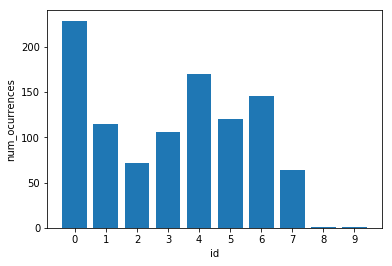

In [15]:
plotDictionary(answer2[0])

In [16]:
t = plot_table(answer2[0])
t

,energy,id,num_occurrences,sample
0,-4.0,0,229,"{'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0'..."
1,-4.0,1,115,"{'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0'..."
2,-4.0,2,72,"{'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0'..."
3,-4.0,3,106,"{'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0'..."
4,-4.0,4,170,"{'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0'..."
5,-4.0,5,120,"{'1c0': 1, '1c1': 0, '2c0': 0, '2c1': 1, '3c0'..."
6,-4.0,6,146,"{'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0'..."
7,-4.0,7,64,"{'1c0': 0, '1c1': 1, '2c0': 1, '2c1': 0, '3c0'..."
8,-2.0,8,1,"{'1c0': 0, '1c1': 1, '2c0': 0, '2c1': 1, '3c0'..."
9,-2.0,9,1,"{'1c0': 0, '1c1': 1, '2c0': 0, '2c1': 1, '3c0'..."


## Simulator Results

# Test 7

## Quantum Computer Results

processing  graph.txt ... 


/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


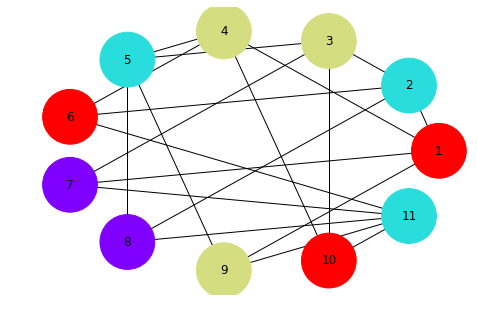

execution time:  3.508519172668457


In [56]:
answer2 = try_k_coloring(4, "graph.txt")

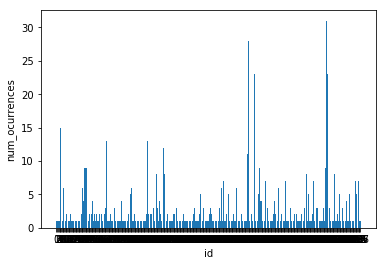

In [58]:
plotDictionary(answer2[0])

## Simulator Results

processing  graph.txt ... 


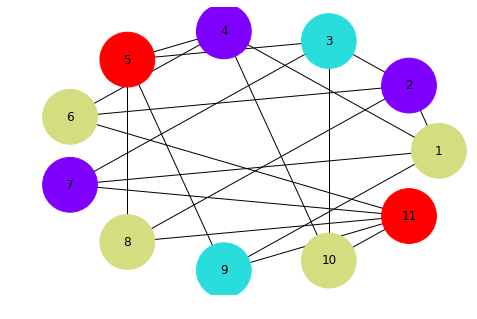

execution time:  0.6892199516296387


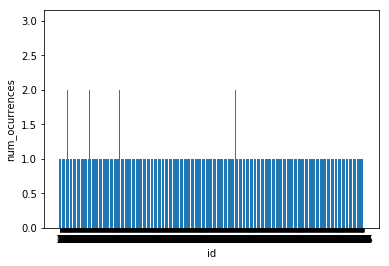

In [23]:
answer2 = try_k_coloring(4, "graph.txt", True)
